
---
# Unit03: Processing passive seismic data

This notebook has some practical processing activities of the Course **ProSeisSN**. It deals with data processing using a passive seismic dataset using [ObsPy](https://docs.obspy.org/).

#### Dependencies: Obspy, Numpy, Matplotlib

#### Reset the Jupyter/IPython notebook in order to run it again, press:
***Kernel*** -> ***Restart & Clear Output***

In [10]:
# Import Libraries
import numpy as np

#%matplotlib inline
%matplotlib widget

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rcParams

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15, 4
plt.rcParams['lines.linewidth'] = 0.5

# Import specialized ObsPy packages + sanity.
try:
    import obspy
    print('obspy version==>', obspy.__version__)
except TypeError:
    print('Stopping RUNTIME. ObsPy not found.')
    exit()

from obspy import read
from obspy import Stream
from obspy import UTCDateTime
from obspy import read, Stream
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.header import FDSNException

obspy version==> 1.2.2


---
## Accessing data

We work with data form an event occured in Acre in 2024,

|EventID | Time | Lat | Long | Depth(km) | Mww | Location |
| :- | :-: | :- | :- | :-: | :-: | :- |
|11793085|2024-01-20T21:31|-7.2879|-71.464|607|6.6|WESTERN BRAZIL|

As recorded at station IU HKT, distant $44^{\circ}$ from the event. We have two options:

- **Read** the data locally $\Longrightarrow$ skip next code, or

- **Retrive** the data from client **IRIS** $\Longrightarrow$ run next code skipping the next one.

In [ ]:
"""
=========== ONLY RUN THIS CODE TO RETRIEVE THE DATA FROM IRIS. SKIP THE NEXT CODE =========== 
"""
# Specify event's start and end times
starttime = UTCDateTime("2024-01-20T21:37:19.019539Z") - 60
endtime = UTCDateTime("2024-01-20T21:58:18.994539Z")
print(starttime, endtime)

# Use wildcards to select all three HH* channels
net = "IU"
sta = "HKT"
loc = "00"
chan = "HH*"

# Specify client. Opt:from obspy.clients.earthworm import Client
# Get waveforms with instrument response into a stream
# List of ObsPy clients: clients = ["IRIS", "NCEDC", "USGS", "GEONET", "RESIF", "INGV", "BGR", "ODC", "SCEDC"]
try:
  client = Client("IRIS")
  st = client.get_waveforms(net, sta, loc, chan, starttime, endtime, attach_response = True)
except FDSNException:
  print(f"Chosen client is not working.")
  from obspy.clients.earthworm import Client
  client = Client("ETH")
  st = client.get_waveforms(net, sta, loc, chan, starttime, endtime, attach_response = True)

# Remove the instrument response in all the 3 components/traces.
st.remove_response(output = 'VEL')

In [11]:
"""
=========== ONLY RUN THIS CODE TO READ THE DATA LOCALLY ===========
"""
# Read the data into a stream object
st = read('wb11793085r.msd')


Stream of Acre event at station IU HKT:
 3 Trace(s) in Stream:
IU.HKT.00.HH1 | 2024-01-20T21:36:19.028394Z - 2024-01-20T21:43:14.538394Z | 100.0 Hz, 41552 samples
IU.HKT.00.HH2 | 2024-01-20T21:36:19.028394Z - 2024-01-20T21:43:17.648394Z | 100.0 Hz, 41863 samples
IU.HKT.00.HHZ | 2024-01-20T21:36:19.028394Z - 2024-01-20T21:43:17.688394Z | 100.0 Hz, 41867 samples
Characteristis for the Z-component:
          network: IU
         station: HKT
        location: 00
         channel: HHZ
       starttime: 2024-01-20T21:36:19.028394Z
         endtime: 2024-01-20T21:43:17.688394Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 41867
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'M', 'number_of_records': 748, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 512, 'filesize': 1145856})


<IPython.core.display.Javascript object>


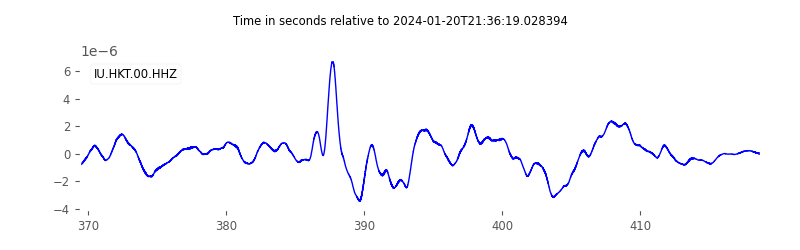

IU.HKT.00.HHZ | 2024-01-20T21:36:19.028394Z - 2024-01-20T21:43:17.688394Z | 100.0 Hz, 41867 samples

In [40]:
# Print stream information and plot the z-component
print(f"Stream of Acre event at station IU HKT:\n {st}")
print(f"Characteristis for the Z-component:\n {st[-1].stats}")

# Make a deep copy of the Z-component
trZ = st[-1].copy()

# Plot the z-component
#                     +──+─> x-axis in duration (s)                           
trZ.plot(color='blue', type='relative', handle=True)
#                                      +────+─> Returns a matplotlib figure instance 

trZ

---
# ==> My memos from Volcanoseismology <== to be deleted!

- lecture_14_theory_fourier.ipynb

- lecture_15_theory_filter.ipynb

- lecture_16_theory_spectral_analysis_preprocessing.ipynb

- lecture_18_obspy_signal_processing.ipynb

- Crash course Python com Colab. Use for programing. Do not include obspy.


---
## Data Trimming

Remove time segments of the signal.   

Original trace has a duration of 418.66s
Enter a window [t[0] t[1]]s on the trace duration to trim the trace

 Enter t[0] and t[1] (rtn= the whole trace):
40 380
[  40.  380.]


<IPython.core.display.Javascript object>


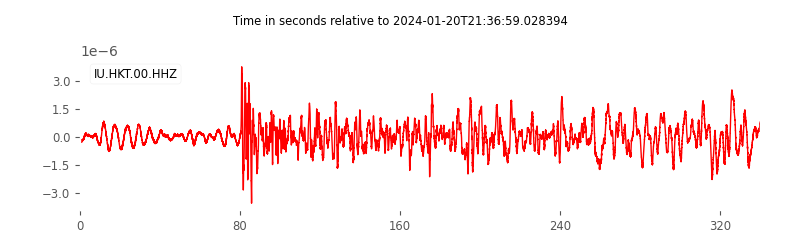

IU.HKT.00.HHZ | 2024-01-20T21:36:59.028394Z - 2024-01-20T21:42:39.028394Z | 100.0 Hz, 34001 samples

In [41]:
print(f"Original trace has a duration of {trZ.stats.endtime - trZ.stats.starttime}s")
print(f"Enter a window [t[0] t[1]]s on the trace duration to trim the trace")

ent = input(f' Enter t[0] and t[1] (rtn= the whole trace):\n') or False
 
#      +───────────────────────────────────────────────+─> string lists <─+─────────────────────+
ent = ['0', str(trZ.stats.endtime - trZ.stats.starttime)] if not ent else ent.rstrip().split(' ')
# Transforms a str list into an ARRAY OF FLOATS
ent = np.array(ent, dtype=float)   

# TRIM trace now ==> NB: trace is modifyed in place!!!
trZ.trim(trZ.stats.starttime + ent[0], trZ.stats.starttime + ent[-1])

#Plot
trZ.plot(color='red', type='relative', handle=True)

trZ

---

## Preprocessing data

**Preprocessing data** is done before any attempt toward any scientific analysis. The needed steps include:

- Detrend and demean the data
- Window the data
- Instrument correction   
- Low-pass filtering
- Downsample or resample the data
- Select a specific window and Pad it with zeros
- Ohter filtering stages.

### The Fourier transform

A great deal of the work is done in the frequency domain where we can analyse the signal according with its energy content by frequency, or its spectral energy contents. The Fourier transform is the tool to achieve that.




For a non-periodic function the interval of periodicity tends to infinity. That means, the steps between neighbouring frequencies become smaller and smaller and thus the infinite sum of the **Fourier series** turns into an integral and we end up with the **integral form** of the **Fourier transformation**:

$$
F(\omega) = \frac{1}{2\pi} \int_{-\infty}^{\infty} f(t) e^{-i\omega t} dt \leftrightarrow f(t) =  \int_{-\infty}^{\infty} F(\omega)e^{i\omega t}dt
$$

Attention: sign and factor conventions can be different in the literature!

In seismology, we do not have continuous but discrete time signals. Therefore, we work with the discrete form of the *Fourier transformation*:

$$
F_k = \frac{1}{N} \sum_{j=0}^{N-1} f_j e^{-2\pi i k j /N} \leftrightarrow f_k = \sum_{j=0}^{N-1} F_j e^{2\pi i k j /N}
$$

where
- $N$ = number of time samples
- $j$ = current sample
- $f_j$ = value of signal at time j
- $k$ = current frequency
- $F_j$ = amount of k in signal (amplitude and phase, complex number)

Frequency recipe = add contribution to frequency from each time spike

Time point =  add contribution to time point from each frequency
